# Raport projektu "Film Finder"

### Zespół 4. Maksim Khameta 307708, Ilya Kharashun 307654, Selivonets Aliaxei 308918

## Spis treści
1. Opis projektu
2. Implementacja<br>
    2.1 Przetwarzanie danych tekstowych<br>
    2.2 Tworzenie modelu zbioru<br>
    2.3 Analiza i wizualizacja danych<br>
3. Działanie programu

## 1. Opis projektu
Projekt polega na stworżeniu i uczeniu modelu, który na podstawie analizy podanych danych tekstowych, a szczególniej 
krótkiego opisu filmu od użytkownika będzie oceniał go wylącznie na podstawie matematyki. Tworzenie modelu polega na analize części atrybutów datasetu (z serwisu Kaggle link: https://www.kaggle.com/stefanoleone992/imdb-extensive-dataset?select=IMDb+movies.csv), przetwarzeniu niektórych atrybutów na wartości liczbowe, standaryzowaniu danych oraz jego uczeniu i testowaniu, będziemy używali 3 sposoby na tworzenie modelu: LinearRegression, RandomForestRegressor i KNeighborsRegressor, który okaże się lepszy, tego będziemy używali w programie końcowym. Wyszkołony model musi być w stanie ocenić film na podstawie jego atrybutów. Ocena końcowa będzie porównana z oryginalnej i pokazano o ile się różni, poszczególne atrybuty będą porównany z atrybutami innych filmów.

## 2 Implementacja
Na początku import wszytkich nezbędnych bibliotek

In [1145]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
from pandas import DataFrame
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from IPython.display import Markdown, display
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maksim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Ninejszy kod czyta dane z datasetu, usuwa obiekty z pustymi komórkami, konwertuje typy danych. Też usunęliśmy atrybuty, które z naszego punktu widzenia nie są potrzebne bo prawie nie mają wpływu na ocenę końcową (np. imdb_title_id, date_published, writer i inne) 

In [1146]:
df = pd.read_csv('movies.csv', low_memory=False)
df = df.drop(['title', 'date_published', 'usa_gross_income', 'writer',
        'worlwide_gross_income', 'metascore', 'imdb_title_id', 'budget'], axis=1)
df = df.dropna()
df = df.reset_index()
df = df.drop('index', axis=1)
df = df.rename(columns={'original_title' : 'title', 'production_company': 'company', 'avg_vote': 'vote', 'reviews_from_critics': 'critics_reviews', 'reviews_from_users': 'users_reviews'})
df = df.drop([64794])
df = df.reset_index()
df = df.drop('index', axis=1)
df['year'] = df['year'].astype(int)
df = df.convert_dtypes()
df.to_csv('project.csv')

Ostateczny dataframe zawira 66094 filma. Przykładowe 5 filmów z końcowymi atrybutami można zobaczyć uruchamiając kod niżej

In [1147]:
df.sample(5)

,title,year,genre,duration,country,language,director,company,actors,description,vote,votes,users_reviews,critics_reviews
54764,Història de la meva mort,2013,Drama,148,"Spain, France, Romania",Catalan,Albert Serra,Andergraun Films,"Vicenç Altaió, Lluís Serrat, Eliseu Huertas, N...","Famous lover Casanova now long past his prime,...",6.5,657,1,35
34548,Soy tu aventura,2003,"Comedy, Musical",110,Argentina,Spanish,"Néstor Montalbano, Carola Poceiro",Barakacine Producciones,"Diego Capusotto, Luis Luque, Luis Aguilé, Veró...","Two bankrupt cousins, who kidnap Luis Aguilé a...",6.5,298,1,1
22233,The Dark Wind,1991,"Drama, Mystery",111,USA,"English, Navajo, Hopi",Errol Morris,Carolco Pictures,"Lance Baker, Betty C. Barlow, Gary Basaraba, B...",A Navajo police officer is mixed up in drug sm...,5.5,546,21,7
16487,Tang lang,1978,"Action, Drama",96,Hong Kong,Mandarin,Chia-Liang Liu,Shaw Brothers,"David Chiang, Cecilia Wong, Lily Li, Chia Yung...",Shaolin Mantis (Orig. Tang lang) is a 1978 Sha...,6.8,540,4,14
3387,Blues in the Night,1941,"Crime, Drama, Film-Noir",88,USA,English,Anatole Litvak,Warner Bros.,"Priscilla Lane, Betty Field, Richard Whorf, Ll...","""Jigger' Lane forms a band that includes singe...",6.8,952,32,18


### 2.1 Przetwarzanie danych tekstowych

Początkowe przerobienie zbioru filmów. Dalej będą potrzebne tylko kolumny nazw, aktorzy i opisów filmów

In [1148]:
d_text = df[['title', 'actors', 'description']]
d_text['title'] = df['title'].astype(str) + '. '
d_text['actors'] = df['actors'].astype(str) + '. '
d_text = d_text.sum(1)
d_text = d_text.convert_dtypes()

lsa = pd.Series()
stop_words = set(stopwords.words('english'))

Przykadowe 5 stringów z nowego setu

In [1149]:
d_text.sample(5)

34837    Os Imortais. Joaquim de Almeida, Emmanuelle Se...
20906    Rent-a-Cop. Burt Reynolds, Liza Minnelli, Jame...
65090    Les Salopes or The Naturally Wanton Pleasure o...
63365    Netemo sametemo. Masahiro Higashide, Erika Kar...
5462     The Blue Lagoon. Jean Simmons, Donald Houston,...
dtype: string

Finkcja zostawiająca w zbiorze słowy w postaci tylko małych literek

In [1150]:
def text_processing(df1):
    for i in df1.index:
        df1[i] = re.sub("[^a-zA-Z]+", " ", df1[i].lower())
        tmp = df1[i].split()
        df1[i] = check_stops(tmp)
    return df1

Funkcja sprawdzająca każde słowo: przerabiamy każde do postaci początkowej słowa przy pomocy PorterStemmer i metody stem(), sprawdzamy czy dane słowo jest stop-słowem. Jeśli jest - nie zwracamy go

In [1151]:
def check_stops(row):
    words = []
    ps = PorterStemmer()
    for i in row:
        i = ps.stem(i)
        if i in stop_words:
            continue
        words.append(str(i))
    return ' '.join(words)

Przerabiamy nasz zbiór stosując dwie powyższe funkcje, wyprowadzamy przykładowych 5 zapisów

In [1152]:
lsa = text_processing(d_text)
lsa.sample(5)

10174    gather eagl rock hudson rod taylor mari peach ...
63966    worth toni todd clifton powel miguel n ez jr e...
64385    sailaja reddi alludu naga chaitanya akkineni a...
47240    badal faqe ahm ezz menna shalabi muhammad lutf...
38767    ultim gift jame garner bill cobb lee meriweth ...
dtype: string

Tworzymy macierz TDM, zawierającą filmy (stringi charakterezujący filmy) w kolumnach i słowy z napisu wejściowego jako wierszy. W macierzy są przechowywane ilości powtórzeń słowa dla każdego filmu

In [1153]:
def create_tdm(s_list):
    tdm = pd.DataFrame(columns=range(len(lsa.index)))
    for s in s_list:
        counter= [0]*len(lsa)
        k = 0
        for row in lsa:
            for word in row.split():
                if s == word:
                    counter[k] += 1 
            k+=1
        element = pd.DataFrame([counter], columns=range(len(lsa.index)), index = [s])
        tdm = tdm.append(element) 
    return tdm

Przykład budowy macierzy TDM z jednym argumentem słowem

In [1154]:
tdm = create_tdm(['miss'])
tdm

,0,1,2,3,4,5,6,7,8,9,...,66084,66085,66086,66087,66088,66089,66090,66091,66092,66093
miss,1,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Funkcja obliczania macierzy TF zawierającą wartości ilorazów liczby wystąpień słowa w filmie i sumy wszystkich słow w danym filmie.

In [1155]:
def create_tf (tdm, tdm_new, a_size, dane_s):
    ile_slow = tdm.count(0)[0]
    tf = np.empty((ile_slow, a_size))
    for i in range(0, a_size):
        if tdm_new.iloc[:, i].sum() != 0:
            tf[:,i] = tdm_new.iloc[:,i]/len(dane_s[i].split())
    return tf

Funkcja obliczania tablicy zawirającej wartości IDF dla poszczególnych słów - iłoraz liczby filmów i liczby filmów, gdzie dane słowo wystąpiło

In [1156]:
def create_idf (tdm, a_size):
    idf = np.log(a_size/np.array((tdm>0)*1).sum(axis=1))
    return idf

Funkcja tworzenia macierzy TF-IDF - iłoraz wartości TF i IDF, miara unikalności danego słowa w kontekscie dokumentu

In [1157]:
def create_tfidf(tdm_new, tf, idf, a_size):
    tfidf = pd.DataFrame((tf*np.array([idf,]*a_size).T*100), columns=tdm_new.columns, index = tdm_new.index)
    #tfidf["w_ilu"] = (np.array((tdm>0)*1).sum(axis=1)).T
    #tfidf["idf"] = idf.T
    return tfidf

Funkcja poszukująca id opisanego użytkownikiem filmu, jako argument podajemy tyłko napis

In [1158]:
def find_id(string):
    tdm = create_tdm(string.split())
    tdm_new = tdm.loc[:, (tdm.sum(axis=0) > 0 )]
    a = np.array(tdm_new.columns)
    
    dane_s = []
    for item in tdm_new.columns:
        dane_s.append(lsa[item])
        
    tf = create_tf(tdm, tdm_new, a.size, dane_s)
    idf = create_idf(tdm, a.size)
    
    tfidf = create_tfidf(tdm_new, tf, idf, a.size)
    
    return tfidf.sum(axis=0).idxmax()

Funkcja przerobienia tekstu wejściowego do potrzebnej postaci. Podobno na przerobienie początkowe zbioru filmów: wszystko do lower case'a, usuwanie znaków niepotrzebnych i stop-słów, analiza morfologiczna każdego słowa. Będzie użyta w ostatnim dziale

In [1159]:
def input_processing(string):
    input_r = re.sub("[^a-zA-Z]+", " ", string.lower())
    ps = PorterStemmer()
    words = []
    for word in input_r.split():
        word = ps.stem(word)
        if word in stop_words:
            continue
        words.append(str(word))
    return ' '.join(words)

Przykład działania powyższej funkcji

In [1160]:
input_processing("The Five Things to Get Right Before the Next Pandemic")

'five thing get right befor next pandem'

### 2.2 Tworzenie modelu zbioru
Tworzymy nowy dataframe na ktrym będą wykonywane czynności do tworzeniu modelu, kopiuemy oryginalny dataset i odrzucamy kolumny: title, actors i description, które nie mają wpływu na ocene

In [1161]:
d_model = df.copy()
d_model = d_model.drop(columns=['title', 'actors', 'description'])

Przykładowe 5 filmów nowego zbióru można zobaczyć uruchamiając kod niżej

In [1162]:
d_model.sample(5)

,year,genre,duration,country,language,director,company,vote,votes,users_reviews,critics_reviews
57516,2015,"Comedy, Crime, Drama",94,Switzerland,German,Micha Lewinsky,Plan B Film,6.7,299,4,21
12549,1970,"Family, Adventure, Animation",90,USA,English,"Chuck Jones, Abe Levitow",Chuck Jones Enterprises,6.9,2818,45,15
44192,2008,Thriller,88,"Iceland, Germany, Netherlands","Icelandic, Dutch, English",Óskar Jónasson,Bavaria Pictures,6.7,2231,13,17
47292,2012,"Drama, Romance",112,USA,"English, French, Spanish, Italian, Sign Langua...",Terrence Malick,Brothers K Productions,5.9,26805,151,312
32454,2002,"Drama, Romance, War",104,USA,English,Jay Craven,Evans Printing Co.,4.8,182,12,3


Następnie musimy zamienić wszystkie wartości na liczbowe. Zasada zamiany jest następująca: ile razy dana wartość atrybutu występuje w tabeli, zastępujemy ją taką liczbą. Ale najpierw musimy oddzielić wartości, jeśli jest ich kilka naraz, na przykład 2 języki, do tego uywamy funkcji explode

In [1163]:
def explode(df, lst_cols, fill_value='', preserve_index=False):
    if (lst_cols is not None
        and len(lst_cols) > 0
        and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    idx_cols = df.columns.difference(lst_cols)
    lens = df[lst_cols[0]].str.len()
    idx = np.repeat(df.index.values, lens)
    res = (pd.DataFrame({
                col:np.repeat(df[col].values, lens)
                for col in idx_cols},
                index=idx)
             .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    if (lens == 0).any():
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    res = res.sort_index()
    if not preserve_index:        
        res = res.reset_index(drop=True)
    return res

d_model = d_model.assign(genre=df.genre.str.split(','))
d_model = d_model.assign(country=df.country.str.split(','))
d_model = d_model.assign(language=df.language.str.split(','))
d_model = d_model.assign(director=df.director.str.split(','))

for item in ['genre', 'country', 'language', 'director']: 
    d_model = explode(d_model, item, fill_value='', preserve_index=True)
    d_model[item] = d_model[item].str.strip()

Teraz dataframe zawiera około 3 razy więcej liniek, ale z zachowaniem indeksów, dodatkowe linie zapisują się pod daną

In [1164]:
d_model.iloc[62972:62977]

,company,country,critics_reviews,duration,genre,language,users_reviews,vote,votes,year,director
17858,Andre Libik,Hungary,1,105,Crime,Hungarian,8,5.9,110,1983,Sándor Simó
17858,Andre Libik,West Germany,1,105,Crime,Hungarian,8,5.9,110,1983,Sándor Simó
17858,Andre Libik,USA,1,105,Crime,Hungarian,8,5.9,110,1983,Sándor Simó
17858,Andre Libik,Hungary,1,105,Drama,Hungarian,8,5.9,110,1983,Sándor Simó
17858,Andre Libik,West Germany,1,105,Drama,Hungarian,8,5.9,110,1983,Sándor Simó


Tworzymy kopie oryginalnego dataframu, następnie liczymy iłosć wystąpień poszczególnych atrybutów i przypisujemy im wartości liczbowe, wartość końcowa atrybutów danego filma jest średnią wartością atrybutów jeżeli są ich wiele

In [1165]:
mem_model = d_model.copy()
d_model_new = d_model.copy()

genre_dictionary = d_model['genre'].value_counts().to_dict()
country_dictionary = d_model['country'].value_counts().to_dict()
language_dictionary = d_model['language'].value_counts().to_dict()
director_dictionary = d_model['director'].value_counts().to_dict()
company_dictionary = d_model['company'].value_counts().to_dict()

d_model_new['genre'] = mem_model['genre'].apply(lambda x: genre_dictionary.get(x))
d_model_new['country'] = mem_model['country'].apply(lambda x: country_dictionary.get(x))
d_model_new['language'] = mem_model['language'].apply(lambda x: language_dictionary.get(x))
d_model_new['director'] = mem_model['director'].apply(lambda x: director_dictionary.get(x))
d_model_new['company'] = mem_model['company'].apply(lambda x: company_dictionary.get(x))

d_model_new = d_model_new.groupby(level=0).mean()

Teraz wszytkie wartości są typu numierycznego, tabela wygłada następująco

In [1166]:
d_model_new.info()
d_model_new.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66094 entries, 0 to 66093
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   company          66094 non-null  int64  
 1   country          66094 non-null  float64
 2   critics_reviews  66094 non-null  Int64  
 3   duration         66094 non-null  Int64  
 4   genre            66094 non-null  float64
 5   language         66094 non-null  float64
 6   users_reviews    66094 non-null  Int64  
 7   vote             66094 non-null  float64
 8   votes            66094 non-null  Int64  
 9   year             66094 non-null  Int32  
 10  director         66094 non-null  float64
dtypes: Int32(1), Int64(4), float64(5), int64(1)
memory usage: 6.1 MB


,company,country,critics_reviews,duration,genre,language,users_reviews,vote,votes,year,director
13220,9,23015.0,37,101,39359.666667,133476.0,27,5.0,656,1971,26.0
18087,2,11936.0,2,151,80829.000000,3232.5,2,6.9,120,1982,4.0
40049,12,94689.0,153,115,22653.333333,39928.5,129,5.8,82511,2009,61.0
42335,1,720.0,4,95,13515.000000,818.0,3,4.3,127,2019,1.0
63717,263,7589.0,33,96,31525.000000,49033.0,17,5.6,1067,2020,9.5


Pozostaje sprowadzić atrybuty do tego samego zakresu zmienności, robimy standaryzację oprócz samej oceny vote, bedzie potrzebna w tej formie 

In [1167]:
attrs = d_model_new.columns
scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(d_model_new)
scaled_df = pd.DataFrame(scaled_df, columns=attrs)
scaled_df['vote'] = d_model_new['vote']

Teraz wartości tabeli są numeryczne i standaryzowane, dodatkowo pokazana tabela korelacji. Ona pokazuje, że gatunek, długość, liczba recenzji i reżyser są dobrze skorelowane z oceną, można wyróżnic skorelowaność kraju i języka, jest to logicznie, przecieź większość filmów jest z USA i po angielsku. 

,company,country,critics_reviews,duration,genre,language,users_reviews,vote,votes,year,director
17168,-0.366195,-0.565159,0.997987,0.639950,-0.120640,0.022799,0.490451,7.6,0.105954,-0.499280,0.638926
42107,-0.373428,-0.565159,-0.245943,-0.686922,-1.204588,0.973791,-0.192991,3.4,-0.191885,0.584141,-0.645385
62099,-0.365391,-0.994718,1.570849,0.182408,0.145951,-0.083099,0.236750,7.0,-0.009070,0.985408,-0.121522
18058,-0.323598,1.218732,-0.180473,-0.092118,0.389680,0.973791,0.065889,5.8,-0.139302,-0.419026,-0.053926
46493,-0.370213,-0.873210,-0.376882,-0.458151,1.968580,-1.331031,-0.260299,6.6,-0.197530,0.704521,-0.442599


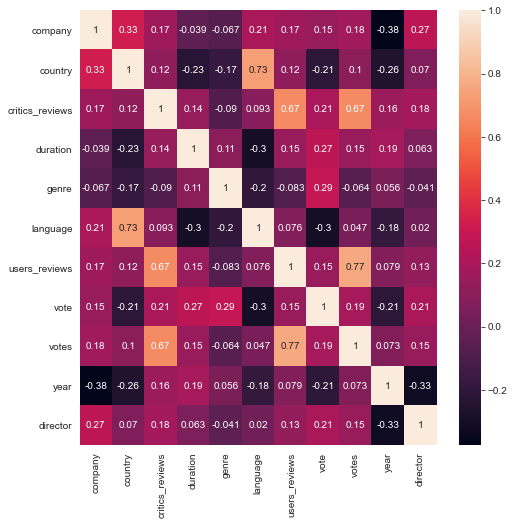

In [1168]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(scaled_df.corr(),annot = scaled_df.corr(), ax = ax)
scaled_df.sample(5)

Etap tworzenia modelu, wykorzystujemy trzy metody regresji. Po kolei tworzymy modele i testujemy je, zapisujemy sukcesowość zbiorów testowych 

In [1188]:
trg = scaled_df[['vote']]
trn = scaled_df.drop(['vote'], axis=1)

models = [LinearRegression(),
RandomForestRegressor(n_estimators=100, max_features ='sqrt'),
KNeighborsRegressor(n_neighbors=5)
]

Xtrn, Xtest, Ytrn, Ytest = train_test_split(trn, trg, test_size=0.3)

TestModels = DataFrame()
tmp = {}
for model in models:
    m = str(model)
    tmp['Model'] = m[:m.index('(')]    
    for i in range(Ytrn.shape[1]):
        model.fit(Xtrn, Ytrn.iloc[:,i]) 
        tmp['R2_Y%s'%str(i+1)] = r2_score(Ytest.iloc[:,0], model.predict(Xtest))
    TestModels = TestModels.append([tmp])
TestModels.set_index('Model', inplace=True)

Wykres słupkowy poniżej pokazuje sukcesywność każdego z modeli, jak widać RandomForest jest najlepszy w naszym przypadku

<AxesSubplot:title={'center':'Lucky percentage '}>

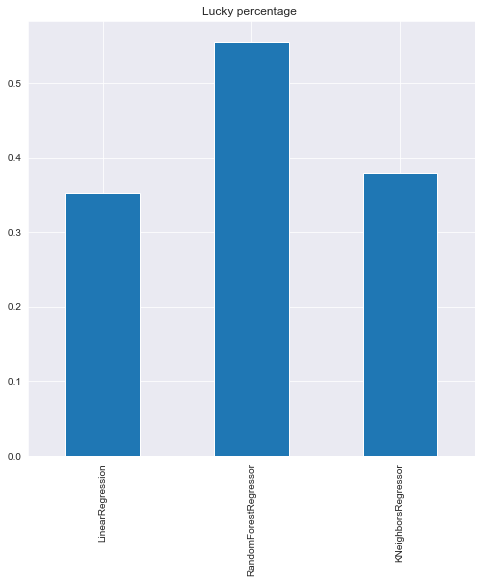

In [1189]:
fig, axs = plt.subplots()
TestModels.R2_Y1.plot(kind='bar', xlabel = '', title='Lucky percentage ', figsize=(8,8))

W tabeli korelacji widzieliśmy, które atrybuty są najbardziej skorelowane z oceną filmu, teraz z tablicy współczynników utworzonego modelu możemy zobaczyć, które atrybuty mają jaką wagę przy obliczaniu wyniku końcowego, dodatkowo wykres kołowy z tymi współczynnikami

company            0.073343
country            0.059041
critics_reviews    0.067399
duration           0.104135
genre              0.153829
language           0.109460
users_reviews      0.072572
votes              0.153249
year               0.125292
director           0.081680
Name: Dependency ratio, dtype: float64


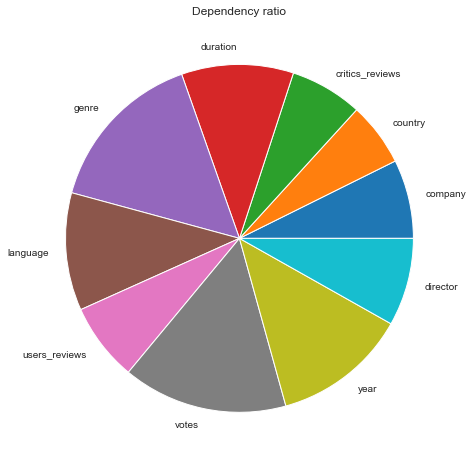

In [1171]:
model = models[1]
model.fit(Xtrn, np.ravel(Ytrn))
model.feature_importances_
coefs = pd.Series(model.feature_importances_, index=scaled_df.columns.drop('vote'), name = 'Dependency ratio')
print(coefs)
plot = coefs.plot.pie(ylabel = '', title='Dependency ratio', figsize=(8, 8), normalize=True)

### 2.3 Analiza a wizualizacja danych
Ponieważ w projekcie szacujemy ocene końcową, zbadamy jej zachowanie. Tu przedstawione podstawowe charakterystyki ocen, gdzie widać że mediana jest większa od średniej, oznacza to, że dobrych filmów mniej niż złych

In [1172]:
df['vote'].describe()

count    66094.000000
mean         5.926331
std          1.208685
min          1.000000
25%          5.300000
50%          6.100000
75%          6.800000
max          9.800000
Name: vote, dtype: float64

Zwizualizujemy dane z oryginalnego datasetu, rozkład ocen filmów, widać, że więcej filmów mieści się około oceny 6, a rozkład ma postać gausoidy

Text(0.5, 1.0, 'Average vote histogram')

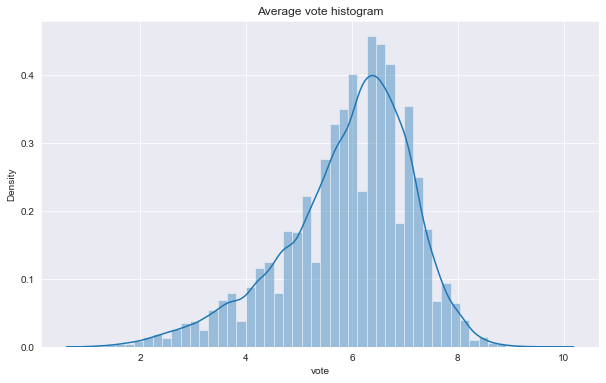

In [1173]:
plt.figure(figsize = (10,6))
sns.set_style("darkgrid")
sns.distplot(a=df['vote'], hist=True, bins=50, kde=True).set_title('Average vote histogram')

Z wykresu pudełkowego i skrzypcowego widać, że zdecydowana większość filmów mieści się w przedziale od 3 do 9, a układ jest prawie wcale symetryczny. Na wykresie pudełkowym można też wyróżnić stosunkowo dużą iłość wartości odstających od głównrgo rozkładu

<AxesSubplot:>

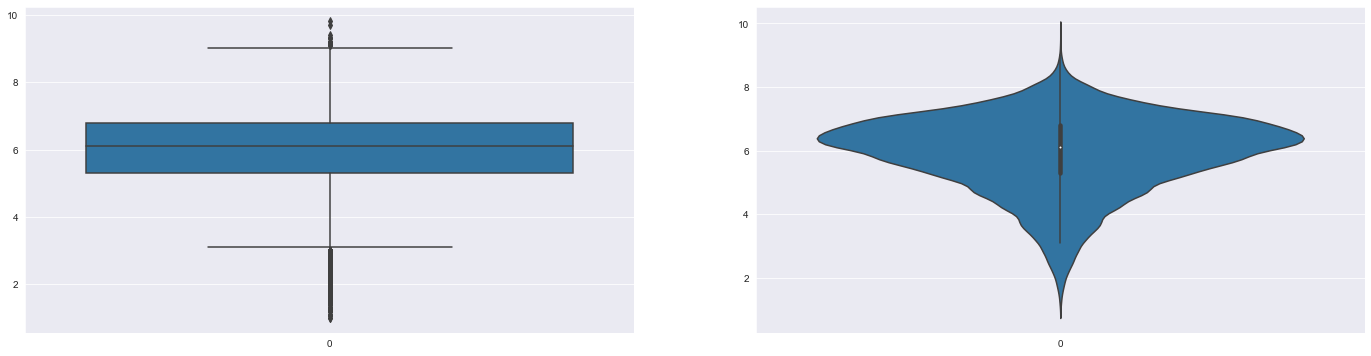

In [1174]:
plt.figure(figsize=(24,6))
plt.subplot(1, 2, 1)
sns.boxplot(data=df['vote'])
plt.subplot(1, 2, 2)
sns.violinplot(data=df['vote'])

Jeśli przeanalizujemy rozkłady filmów np. różnych gatunków, zauważymy, że w zależności od przedziału oceny zmienia się gęstość filmów tych gatunków. 

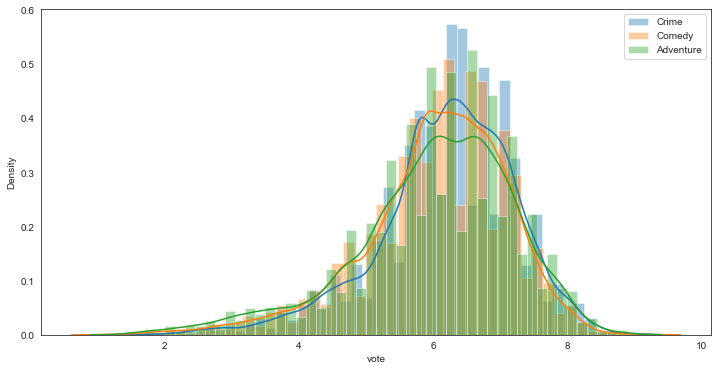

In [1181]:
sns.set_style("white")
plt.figure(figsize = (12,6))
sns.distplot(d_model.loc[d_model.genre == 'Crime', 'vote'], label='Crime')
sns.distplot(d_model.loc[d_model.genre == 'Comedy', 'vote'], label='Comedy')
sns.distplot(d_model.loc[d_model.genre == 'Adventure', 'vote'], label='Adventure')
plt.legend()   
plt.show()

Z wykresu porównującego kraje produkcji filmów widać, że rozkład polskich filmów jest generalnie lepszy niż amerykańskich czy niemieckich, choć jest ich znacznie więcej, to kolejny raz potwierdza ujemną wartość korelacji z tabeli korelacji między atrybutem kraju a oceną filmu

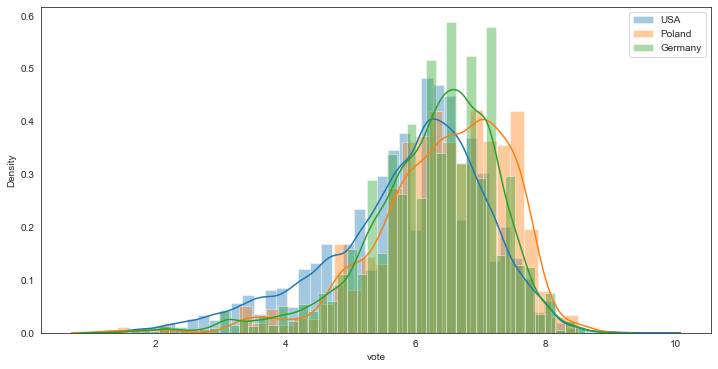

In [1182]:
plt.figure(figsize = (12,6))
sns.distplot(d_model.loc[d_model.country == 'USA', 'vote'], label='USA')
sns.distplot(d_model.loc[d_model.country == 'Poland', 'vote'], label='Poland')
sns.distplot(d_model.loc[d_model.country == 'Germany', 'vote'], label='Germany')
plt.legend()
plt.show()

Z wykresu porównującego języki filmów widać, że rozkład filmów po francuzsku bardziej odpowiada ogólnemu rozkladu, ich gęstość największa około 6-6.5

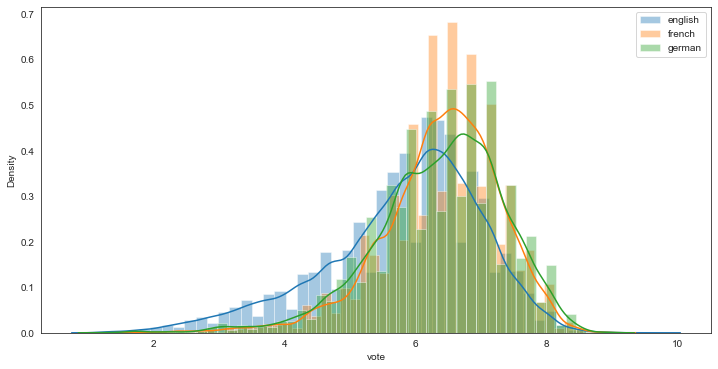

In [1183]:
plt.figure(figsize = (12,6))
sns.distplot(d_model.loc[d_model.language == 'English', 'vote'], label='english')
sns.distplot(d_model.loc[d_model.language == 'French', 'vote'], label='french')
sns.distplot(d_model.loc[d_model.language == 'German', 'vote'], label='german')
plt.legend()
plt.show()

W dziale, w którym stworzyliśmy model, było powiedziano, że większość filmów wyprodukowano w USA i po angielsku, tu są te statystyki 

<BarContainer object of 5 artists>

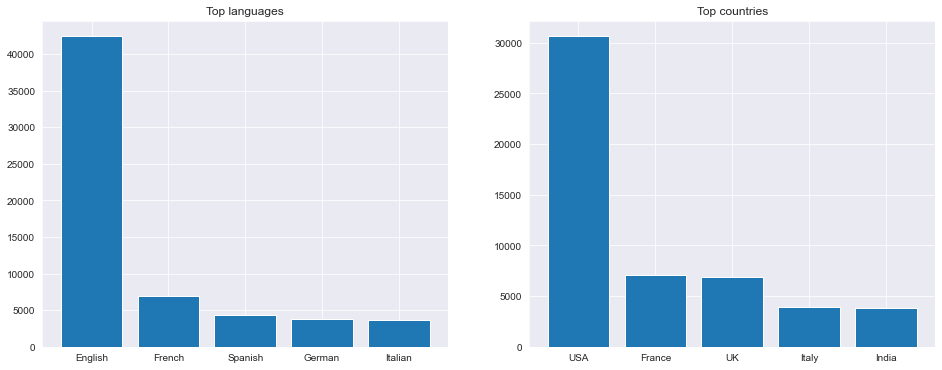

In [1184]:
newdfc = df.copy()
newdfc = newdfc.assign(country=df.country.str.split(','))
newdfc = explode(newdfc, 'country', fill_value='', preserve_index=True)
newdfc['country'] = newdfc['country'].str.strip()
country_dictionary = newdfc['country'].value_counts().to_dict()
country_dictionary = dict(list(country_dictionary.items())[0:5])

newdfl = df.copy()
newdfl = newdfl.assign(language=df.language.str.split(','))
newdfl = explode(newdfl, 'language', fill_value='', preserve_index=True)
newdfl['language'] = newdfl['language'].str.strip()
language_dictionary = newdfl['language'].value_counts().to_dict()
language_dictionary = dict(list(language_dictionary.items())[0:5])

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(16,6))
plt.subplot(1, 2, 1).set_title('Top languages')
plt.bar(language_dictionary.keys(), language_dictionary.values())
plt.subplot(1, 2, 2).set_title('Top countries')
plt.bar(country_dictionary.keys(), country_dictionary.values())

Można również przeanalizować wykresy zależności średniej długości filmu i średniej oceny oraz dodatkowo śródkowej wartości tych atrybutów od roku premiery filmu. Z wykresów dobrze widać, że długość rośnie z roku na rok, a tym czasem wartość oceny spada

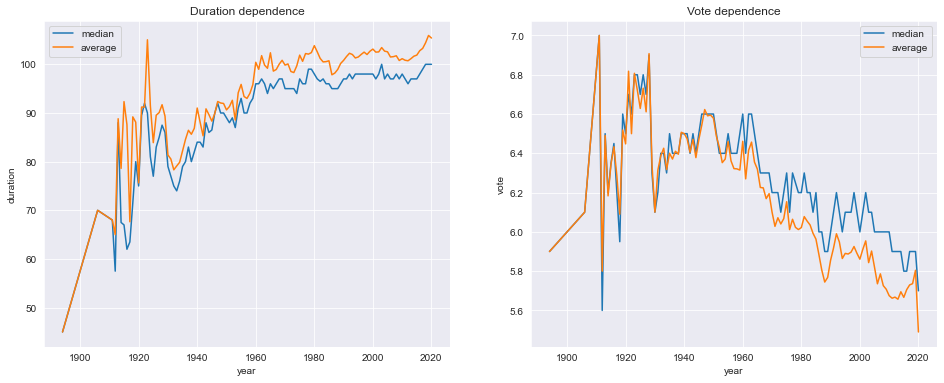

In [1185]:
d_plot = df.groupby('year').mean()
d_plot_2 = df.groupby('year').median()

fig, ax = plt.subplots(figsize=(16,6))
plt.subplot(1, 2, 1).set_title('Duration dependence')
sns.lineplot(x='year', y='duration', data=d_plot_2, label='median')
sns.lineplot(x='year', y='duration', data=d_plot, label='average')
plt.subplot(1, 2, 2).set_title('Vote dependence')
sns.lineplot(x='year', y='vote', data=d_plot_2, label = 'median')
sns.lineplot(x='year', y='vote', data=d_plot, label = 'average')
plt.legend()

Ta funkcja jest potrzebna do porównania oceny danego filmu z innymi, ale przy tych samych atrybuyach. Jej działanie będzie pokazano w następnym działe 

In [1186]:
def visualize(genre, country, language, director, company, vote):
    plt.figure(figsize = (16,18))
    
    plt.subplot(5,1,1)
    sns.distplot(df.loc[df.genre == genre, 'vote'], label=genre)
    plt.axvline(x = vote, ymax = 1, linewidth=14, color='tomato')
    plt.legend()
    plt.xlim(0, 10)
    
    plt.subplot(5,1,2)
    sns.distplot(df.loc[df.language == language, 'vote'], label=language)
    plt.axvline(x = vote, ymax = 1, linewidth=14, color='tomato')
    plt.legend()
    plt.xlim(0, 10)
    
    plt.subplot(5,1,3)
    sns.distplot(df.loc[df.country == country, 'vote'], label=country)
    plt.axvline(x = vote, ymax = 1, linewidth=14, color='tomato')
    plt.legend()
    plt.xlim(0, 10)
    
    plt.subplot(5,1,4)
    sns.distplot(df.loc[df.director == director, 'vote'], label=director)
    plt.axvline(x = vote, ymax = 1, linewidth=14, color='tomato')
    plt.legend()
    plt.xlim(0, 10)
    
    plt.subplot(5,1,5)
    sns.distplot(df.loc[df.company == company, 'vote'], label=company)
    plt.axvline(x = vote, ymax = 1, linewidth=14, color='tomato')
    plt.legend()
    plt.xlim(0, 10)

## 3. Działanie programu
W tej sekcji można przetestować działanie programu, użytkownikowi wystarczy opisać istniający film, który ma zostać oceniony, program natomiast:
1. Będzie szukał filmu odpowiadającego opisu
2. Oszacuje znaleziony film w utworzonym modelu 
3. Poda ocenę i narysuje wykresy porównawcze 

Describe the film:
pirate jack and Turner


**Film:** Pirates of the Caribbean: The Curse of the Black Pearl

**Description:** Blacksmith Will Turner teams up with eccentric pirate "Captain" Jack Sparrow to save his love, the governor's daughter, from Jack's former pirate allies, who are now undead.

**Mashine counted vote:** 8.2

**Original vote:** 8.0

,title,year,genre,duration,country,language,director,company,actors,description,vote,votes,users_reviews,critics_reviews
33652,Pirates of the Caribbean: The Curse of the Bla...,2003,"Action, Adventure, Fantasy",143,USA,English,Gore Verbinski,Walt Disney Pictures,"Johnny Depp, Geoffrey Rush, Orlando Bloom, Kei...",Blacksmith Will Turner teams up with eccentric...,8.0,1001260,2196,292


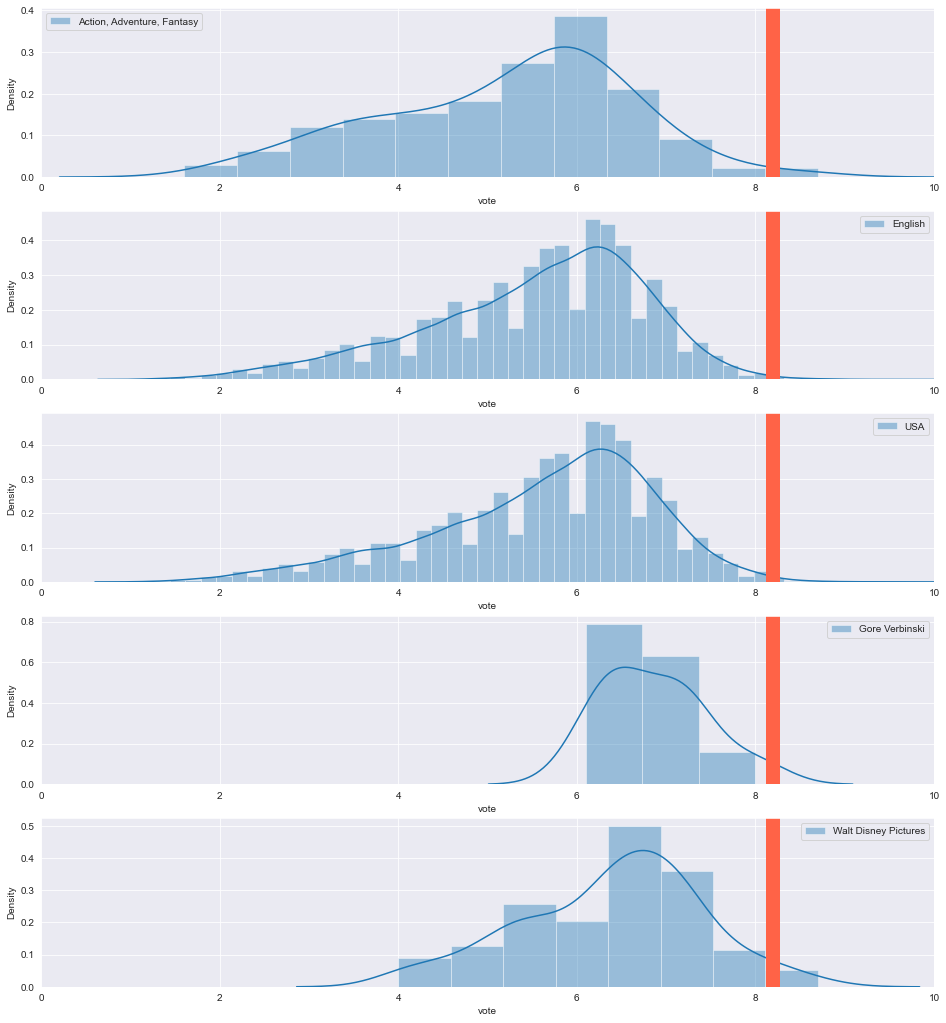

In [1190]:
def program (string):
    index = find_id(input_processing(string))
    film = scaled_df.iloc[index:index+1].drop(columns='vote')
    vote = round(model.predict(film)[0],3)
    
    def printmd(string):
        display(Markdown(string))
    
    attrs = df.loc[index].to_numpy()
    printmd("**Film:** %s" % attrs[0])
    printmd("**Description:** %s" % attrs[9])
    printmd("**Mashine counted vote:** %s" % vote.astype(str))
    printmd("**Original vote:** %s" % attrs[10].astype(str))
    
    visualize(attrs[2], attrs[4], attrs[5], attrs[6], attrs[7], vote)
    
print('Describe the film:')
text = input()

program(text)
df.loc[[index]]